In [6]:
import numpy as np 
import healpy as hp
import matplotlib.pyplot as plt
from glob import glob

In [7]:
nside = 256
npix = 12*nside**2

In [55]:
mapdir = 'noise_only_test/out/'
cov = np.zeros((17, 6, npix))
invcov = np.zeros((17, 6, npix))
nw = np.zeros((17, 3, npix))
m = np.zeros((17, 3, npix))
hits = np.zeros((17, npix))
rcond = np.zeros((17, 3, npix))
for i, schedule in enumerate(sorted(glob(f'{mapdir}schedule0*'))):
    # print(schedule)
    cov[i] = hp.read_map(f'{schedule}/filterbin_cov.fits', field=None)
    invcov[i] = hp.read_map(f'{schedule}/filterbin_invcov.fits', field=None)
    nw[i] = hp.read_map(f'{schedule}/filterbin_noiseweighted_filtered_map.fits', field=None)
    m[i] = hp.read_map(f'{schedule}/filterbin_filtered_map.fits', field=None)
    hits[i] = hp.read_map(f'{schedule}/filterbin_hits.fits', field=None)
    rcond[i] = hp.read_map(f'{schedule}/filterbin_rcond.fits', field=None)

In [56]:
cov_all = hp.read_map(f'{mapdir}schedule/filterbin_cov.fits', field=None)
invcov_all = hp.read_map(f'{mapdir}schedule/filterbin_invcov.fits', field=None)
nw_all = hp.read_map(f'{mapdir}schedule/filterbin_noiseweighted_filtered_map.fits', field=None)
m_all = hp.read_map(f'{mapdir}schedule/filterbin_filtered_map.fits', field=None)
hits_all = hp.read_map(f'{mapdir}schedule/filterbin_hits.fits', field=None)
rcond_all = hp.read_map(f'{mapdir}schedule/filterbin_rcond.fits', field=None)

In [58]:
def get_3x3(cov, pixel):
    cov_pp = np.array([
        [cov[0][pixel], cov[1][pixel], cov[2][pixel]], 
        [cov[1][pixel], cov[3][pixel], cov[4][pixel]], 
        [cov[2][pixel], cov[4][pixel], cov[5][pixel]] ], dtype=np.float64)
    
    return cov_pp

def apply_cov(cov, m):
    new_map = np.zeros_like(m)

    for pixel in observed_pixels:
        m_pp = np.array([
            [m[0][pixel]],
            [m[1][pixel]],
            [m[2][pixel]] ], dtype=np.float64
        )
        cov_pp = get_3x3(cov, pixel)
        reconstructed_pixel = cov_pp @ m_pp
        new_map[:, pixel] = reconstructed_pixel.flatten()
        
    return new_map

def invert_cov(cov):
    invcov = np.zeros_like(cov)
    
    for pixel in observed_pixels:
        matrix = get_3x3(cov, pixel)
        inv_matrix = np.linalg.pinv(matrix, rcond=1e-3)
            
        if not np.allclose(inv_matrix @ matrix, np.identity(3)):
            inv_matrix = np.zeros((3,3))

        invcov[:,pixel] = np.array([
            inv_matrix[0][0],
            inv_matrix[0][1],
            inv_matrix[0][2],
            inv_matrix[1][1],
            inv_matrix[1][2],
            inv_matrix[2][2] ], dtype=np.float64)
        
    return invcov

In [61]:
nw_coadd = np.sum(nw, axis=0)
invcov_coadd = np.sum(invcov, axis=0)
# m_coadd = 1/invcov_coadd*nw_coadd

In [62]:
total_hits = np.sum(hits, axis=0)
observed_pixels = np.where(total_hits!=0)[0]
nw_coadd = np.sum(nw, axis=0)
invcov_coadd = np.sum(invcov, axis=0)

In [67]:
cov_coadd = invert_cov(invcov_coadd)
m_coadd = apply_cov(cov_coadd, nw_coadd)

In [80]:
np.nanmax(np.abs((m_coadd - m_all) / m_all))

/tmp/ipykernel_29814/2665491883.py:1: RuntimeWarning: invalid value encountered in divide
  np.nanmax(np.abs((m_coadd - m_all) / m_all))


2.755588177868952e-08

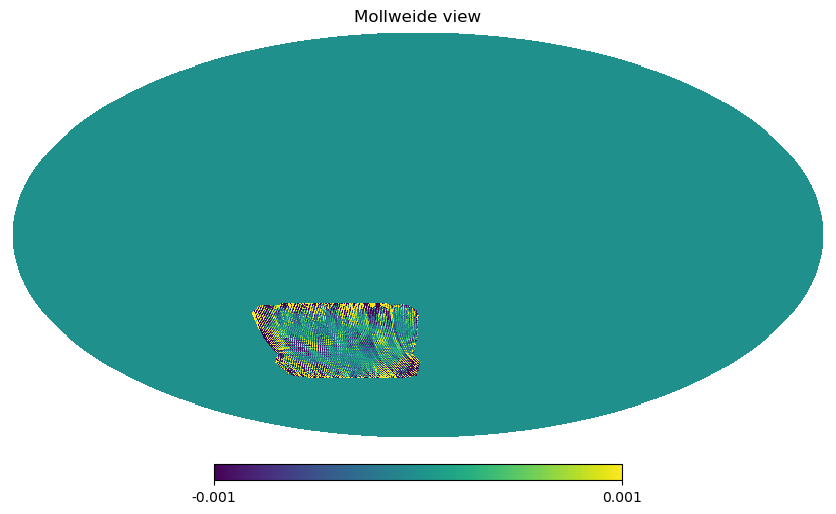

In [86]:
hp.mollview(m_all[0], min=-1e-3, max=1e-3)